# 1. Setup

In [44]:
# import system modules
import time
import sys
import os
from random import randint
import itertools

# import third-party modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import msprime

# import comparrison modules
import tskit
import dendropy

# import local phylokit modules
phylokit_path = os.path.abspath(os.path.join(os.pardir))
if phylokit_path not in sys.path:
    sys.path.append(phylokit_path)

import phylokit as pk

# set recursion limit
sys.setrecursionlimit(10000)

In [45]:
# Constants
LEAVES = 100000
REPEAT = 10

MIN_LEAVES = 100
MAX_LEAVES = 1000
STEP = 100

NUM_LEAVES = list(range(MIN_LEAVES, MAX_LEAVES, STEP))

### CPU INFO

In [46]:
if sys.platform.startswith('linux'):
    !lscpu
elif sys.platform.startswith('darwin'):
    !sysctl -n machdep.cpu.brand_string
elif sys.platform.startswith('win'):
    !wmic cpu get name

Apple M1 Pro


# 2. Utility functions

In [47]:
def get_tree1(num_leaves):
    """
    Generate three trees with different format

    param: num_leaves int: number of leaves in the tree
    return: tsk_tree tskit.Tree: tskit tree,
            phylokit_tree xarray.DataSet: phylokit tree,
            dendropy_tree dendropy.Tree: dendropy tree
    """
    tsk_tree = msprime.sim_ancestry(samples=num_leaves, ploidy=1, random_seed=10086).first(sample_lists=True)
    #TODO update this to new dataset interface
    pk_tree = tsk_tree # pk_tree = pk.from_tskit(tsk_tree)

    newick_tree = tsk_tree.as_newick()
    dendropy_tree = dendropy.Tree.get(data=newick_tree, schema="newick")
    return tsk_tree, pk_tree, dendropy_tree

def get_tree2(num_leaves):
    tsk_tree = msprime.sim_ancestry(samples=num_leaves, ploidy=1, random_seed=2022).first(sample_lists=True)
    #TODO update this to new dataset interface
    pk_tree = tsk_tree # pk_tree = pk.from_tskit(tsk_tree)

    newick_tree = tsk_tree.as_newick()
    dendropy_tree = dendropy.Tree.get(data=newick_tree, schema="newick")
    return tsk_tree, pk_tree, dendropy_tree

# Time comparison with different package

## 1. MRCA

In [56]:
mrca_tsk = []
mrca_pk = []
mrca_dendropy = []

# generate three trees
tsk_tree, pk_tree, dendropy_tree = get_tree1(LEAVES)

mrca_tsk_temp = []
mrca_pk_temp = []
mrca_dendropy_temp = []

u = randint(0, LEAVES)
v = randint(0, LEAVES)

# for dendropy
taxon_labels = ["n" + str(u), "n" + str(v)]

# warm up
tsk_tree.mrca(u, v)
pk.mrca(pk_tree, u, v)
dendropy_tree.mrca(taxon_labels=taxon_labels)

for j in trange(REPEAT):
    tsk_start = time.time()
    tsk_tree.mrca(u, v)
    tsk_end = time.time()
    mrca_tsk_temp.append(tsk_end - tsk_start)

    pk_start = time.time()
    pk.mrca(pk_tree, u, v)
    pk_end = time.time()
    mrca_pk_temp.append(pk_end - pk_start)

    dendropy_start = time.time()
    dendropy_tree.mrca(taxon_labels=taxon_labels)
    dendropy_end = time.time()
    mrca_dendropy_temp.append(dendropy_end - dendropy_start)

100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


In [57]:
tsk_mrca = np.mean(mrca_tsk_temp)
pk_mrca = np.mean(mrca_pk_temp)
dendropy_mrca = np.mean(mrca_dendropy_temp)

print("Tskit:", tsk_mrca, "s")
print("Phylokit:", pk_mrca, "s")
print("Dendropy:", dendropy_mrca, "s")

Tskit: 1.0657310485839844e-05 s
Phylokit: 0.0028417348861694337 s
Dendropy: 0.06031038761138916 s


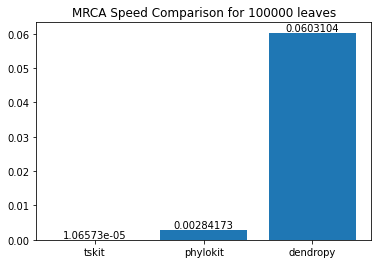

In [58]:
names = ['tskit', 'phylokit', 'dendropy']
values = [tsk_mrca, pk_mrca, dendropy_mrca]

p = plt.bar(names, values, align='center')
plt.title("MRCA Speed Comparison for {} leaves".format(LEAVES))
plt.bar_label(p)
plt.show()

## 2. Kendall-Colijn distance

In [ ]:
kc_tsk = []
kc_pk = []

progress = tqdm(NUM_LEAVES, position=0)

for i in progress:
    progress.set_description("{} leaves".format(i))

    # generate three trees
    tsk_tree1, pk_tree1, dendropy_tree1 = get_tree1(i)
    tsk_tree2, pk_tree2, dendropy_tree2 = get_tree2(i)

    kc_pk_temp = []
    kc_tsk_temp = []

    # warm up
    tsk_tree1.kc_distance(tsk_tree2, 1)
    pk.kc_distance(pk_tree1, pk_tree2, 1)

    for _ in range(REPEAT):
        tsk_start = time.time()
        tsk_tree1.kc_distance(tsk_tree2, 1)
        tsk_end = time.time()
        kc_tsk_temp.append(tsk_end - tsk_start)

        pk_start = time.time()
        pk.kc_distance(pk_tree1, pk_tree2, 1)
        pk_end = time.time()
        kc_pk_temp.append(pk_end - pk_start)
        
    kc_tsk.append(np.mean(kc_tsk_temp))
    kc_pk.append(np.mean(kc_pk_temp))


900 leaves: 100%|██████████| 9/9 [00:03<00:00,  2.35it/s]


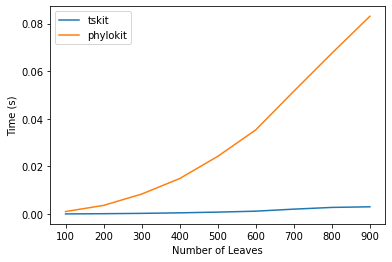

In [ ]:
plt.plot(NUM_LEAVES, kc_tsk, label='tskit')
plt.plot(NUM_LEAVES, kc_pk, label='phylokit')
plt.xlabel("Number of Leaves")
plt.ylabel("Time (s)")
plt.legend()
plt.show()

In [ ]:
def naive_kc_distance(tree1, tree2, lambda_=0):
    """
    Returns the Kendall-Colijn distance between the specified pair of trees.
    lambda_ determines weight of topology vs branch lengths in calculating
    the distance. Set lambda_ at 0 to only consider topology, set at 1 to
    only consider branch lengths. See Kendall & Colijn (2016):
    https://academic.oup.com/mbe/article/33/10/2735/2925548
    """
    samples = tree1.tree_sequence.samples()
    if not np.array_equal(samples, tree2.tree_sequence.samples()):
        raise ValueError("Trees must have the same samples")
    if not len(tree1.roots) == len(tree2.roots) == 1:
        raise ValueError("Trees must have one root")
    for tree in [tree1, tree2]:
        for u in tree.nodes():
            if tree.num_children(u) == 1:
                raise ValueError("Unary nodes are not supported")

    n = samples.shape[0]
    N = (n * (n - 1)) // 2
    m = [np.zeros(N + n), np.zeros(N + n)]
    M = [np.zeros(N + n), np.zeros(N + n)]
    for tree_index, tree in enumerate([tree1, tree2]):
        for sample in range(n):
            m[tree_index][N + sample] = 1
            M[tree_index][N + sample] = tree.branch_length(sample)

        for n1, n2 in itertools.combinations(range(n), 2):
            mrca = tree.mrca(samples[n1], samples[n2])
            depth = 0
            u = tree.parent(mrca)
            while u != tskit.NULL:
                depth += 1
                u = tree.parent(u)
            pair_index = n1 * (n1 - 2 * n + 1) // -2 + n2 - n1 - 1
            m[tree_index][pair_index] = depth
            M[tree_index][pair_index] = tree.time(tree.root) - tree.time(mrca)

    return np.linalg.norm((1 - lambda_) * (m[0] - m[1]) + lambda_ * (M[0] - M[1]))

In [ ]:
kc_naive = []
kc_pk = []

progress = tqdm(NUM_LEAVES, position=0)

for i in progress:
    progress.set_description("{} leaves".format(i))

    # generate trees
    tsk_tree1, pk_tree1, dendropy_tree1 = get_tree1(i)
    tsk_tree2, pk_tree2, dendropy_tree2 = get_tree2(i)

    kc_naive_temp = []
    kc_pk_temp = []

    # warm up
    naive_kc_distance(tsk_tree1, tsk_tree2, 1)
    pk.kc_distance(pk_tree1, pk_tree2, 1)

    for _ in range(REPEAT):
        naive_start = time.time()
        naive_kc_distance(tsk_tree1, tsk_tree2, 1)
        naive_end = time.time()
        kc_naive_temp.append(naive_end - naive_start)

        pk_start = time.time()
        pk.kc_distance(pk_tree1, pk_tree2, 1)
        pk_end = time.time()
        kc_pk_temp.append(pk_end - pk_start)
    
    kc_naive.append(np.mean(kc_naive_temp))
    kc_pk.append(np.mean(kc_pk_temp))


900 leaves: 100%|██████████| 9/9 [01:10<00:00,  7.88s/it]


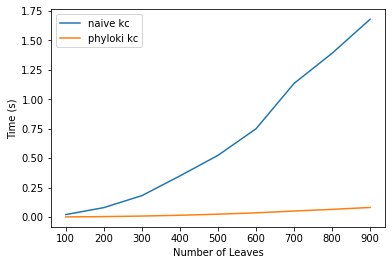

In [ ]:
plt.plot(NUM_LEAVES, kc_naive, label='naive kc')
plt.plot(NUM_LEAVES, kc_pk, label='phyloki kc')
plt.xlabel("Number of Leaves")
plt.ylabel("Time (s)")
plt.legend()
plt.show()